In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
numpyro.set_host_device_count(10)

import numpy as np
from jax import numpy as jnp
from jax import random
from tqdm import trange
from numpyro import plate, sample, factor, deterministic
from numpyro.distributions import Normal, Uniform
from numpyro.infer import MCMC, NUTS, init_to_median

import matplotlib.pyplot as plt
import scienceplots

from scipy.stats import norm
import candel

SPEED_OF_LIGHT = candel.SPEED_OF_LIGHT

In [16]:
def r2mu(r):
    return 5 * jnp.log10(r) + 25

def mu2r(mu):
    return 10**((mu - 25) / 5)

def r2czcosmo(r, H0=70):
    return r * H0


def generate_mock_sample(N_galaxies, N_Cepheids_per_galaxy, Rmax, M_SN,
                         e_mag_SN, M_Cepheid, e_mag_Cepheid, H0, sigma_v,
                         mag_limit_SN=None, cz_limit=None, seed=46,
                         mu_calib_true=(18.5, 30.0), e_mu_calibration=0.25,
                         oversample_factor=2):
    rng = np.random.default_rng(seed)
    sample_r = lambda n: Rmax * rng.uniform(0, 1, n)**(1/3)

    # --- rejection sampling of galaxy distances ---
    r_list = []
    cz_list = []
    mu_list = []
    m_SN_list = []

    batch_size = oversample_factor * N_galaxies

    while len(r_list) < N_galaxies:
        r_batch = sample_r(batch_size)
        mu_batch = r2mu(r_batch)
        m_SN_batch = mu_batch + M_SN + rng.normal(0, e_mag_SN, size=r_batch.shape)

        cz_cosmo_batch = r2czcosmo(r_batch, H0=H0)
        cz_obs_batch = rng.normal(cz_cosmo_batch, sigma_v)

        # Apply SN apparent magnitude cut
        mask = np.ones_like(m_SN_batch, dtype=bool)
        if mag_limit_SN is not None:
            mask &= m_SN_batch < mag_limit_SN

        if cz_limit is not None:
            mask &= cz_obs_batch < cz_limit

        r_list.append(r_batch[mask])
        mu_list.append(mu_batch[mask])
        cz_list.append(cz_obs_batch[mask])
        m_SN_list.append(m_SN_batch[mask])

    # Flatten and truncate to N_galaxies exactly
    r_gal = np.concatenate(r_list)[:N_galaxies]
    mu_gal = np.concatenate(mu_list)[:N_galaxies]
    cz_gal = np.concatenate(cz_list)[:N_galaxies]
    m_SN_gal = np.concatenate(m_SN_list)[:N_galaxies]

    # --- expand each galaxy into Cepheids at same distance ---
    mu_all = np.repeat(mu_gal, N_Cepheids_per_galaxy)

    mag_all = mu_all + M_Cepheid + rng.normal(0, e_mag_Cepheid, size=mu_all.shape)

    # --- calibration sample ---
    mu_calibration_true = jnp.asarray(mu_calib_true)
    mu_calibration = mu_calibration_true + rng.normal(0,e_mu_calibration, size=mu_calibration_true.shape)
    mag_calibration = np.repeat(mu_calibration_true, N_Cepheids_per_galaxy) + M_Cepheid + rng.normal(0, e_mag_Cepheid, size=len(mu_calibration_true) * N_Cepheids_per_galaxy)

    ks_Cepheid = np.repeat(np.arange(N_galaxies), N_Cepheids_per_galaxy)
    ks_calibration = np.repeat(np.arange(len(mu_calibration_true)), N_Cepheids_per_galaxy)

    return r_gal, mag_all, m_SN_gal,cz_gal, mu_calibration, mag_calibration, ks_Cepheid, ks_calibration

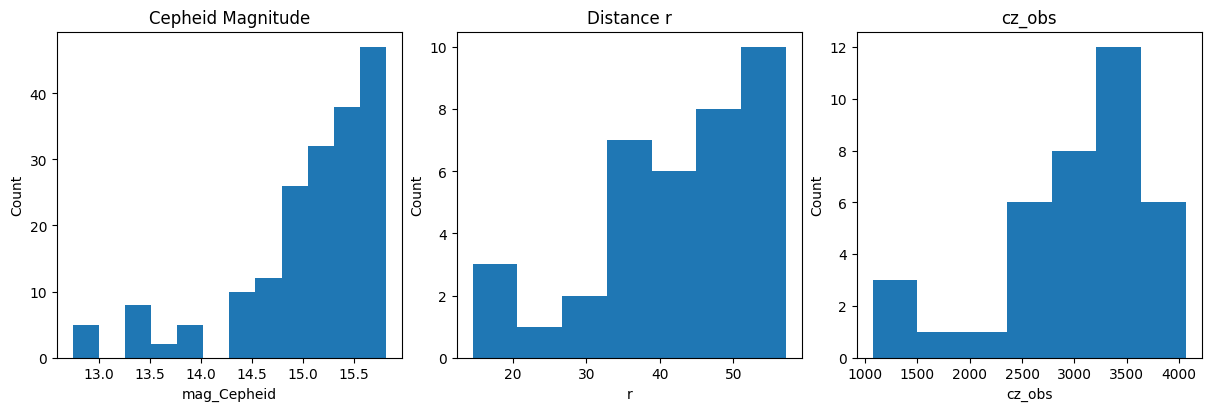

In [68]:
N_galaxies = 37
N_Cepheids_per_galaxy = 5
Rmax = 100
M_SN = -19.25
e_mag_SN = 0.1
M_Cepheid = -18
e_mag_Cepheid = 0.05
H0 = 70
sigma_v = 250
e_mu_calibration = 0.25

mag_limit_SN = 14.5
cz_limit = None

mock_kwargs = dict(N_galaxies=N_galaxies, N_Cepheids_per_galaxy=N_Cepheids_per_galaxy,
                   Rmax=Rmax, M_SN=M_SN, e_mag_SN=e_mag_SN,
                   M_Cepheid=M_Cepheid, e_mag_Cepheid=e_mag_Cepheid, H0=H0,
                   sigma_v=sigma_v, mag_limit_SN=mag_limit_SN, cz_limit=cz_limit,
                   e_mu_calibration=e_mu_calibration)

r, mag, m_SN, cz, mu_calibration, mag_calibration, ks_Cepheid, ks_calibration = generate_mock_sample(**mock_kwargs)


fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

axes[0].hist(mag, bins="auto")
axes[0].set_title('Cepheid Magnitude')
axes[0].set_xlabel('mag_Cepheid')
axes[0].set_ylabel('Count')

axes[1].hist(r, bins="auto")
axes[1].set_title('Distance r')
axes[1].set_xlabel('r')
axes[1].set_ylabel('Count')

axes[2].hist(cz, bins="auto")
axes[2].set_title('cz_obs')
axes[2].set_xlabel('cz_obs')
axes[2].set_ylabel('Count')

plt.show()

In [69]:
from jax.scipy.stats import norm as norm_jax
from candel.model import ln_simpson

def get_log_S_cz(H0, sigma_v, cz_lim=3300):
    Rmax = 100
    r = jnp.linspace(1e-3, Rmax, 300)

    cz_r = r2czcosmo(r, H0=H0)
    log_cdf = norm_jax.logcdf((cz_lim - cz_r) / sigma_v)
    log_integral = ln_simpson(2 * jnp.log(r) + log_cdf, x=r)
    return jnp.log(3) - 3 * jnp.log(Rmax) + log_integral


def get_log_S_mag(M):
    Rmax = 100
    e_mag = 0.1
    r = jnp.linspace(1e-3, Rmax, 300)

    mag = r2mu(r) + M
    log_cdf = norm_jax.logcdf((mag_limit_SN - mag) / e_mag)
    log_integral = ln_simpson(2 * jnp.log(r) + log_cdf, x=r)
    return jnp.log(3) - 3 * jnp.log(Rmax) + log_integral

def model(mag_Cepheid, mag_SN, cz_obs, mu_calibration, mag_calibration, ks_Cepheid, ks_calibration):
    H0 = sample("H0", Uniform(10, 100))  # Sample H0 from a normal distribution

    M_Cepheid = sample("M_Cepheid", Normal(-18, 0.5))
    sample("M_Cepheid_ll", Normal(M_Cepheid, 0.025), obs=-18)
    sample("M_Cepheid_ll_2", Normal(M_Cepheid, 0.8), obs=-17.9)


    M_SN = sample("M_SN", Normal(-19.25, 0.5))
    # log_S = get_log_S_cz(H0, sigma_v=250, cz_lim=3300)
    # log_S = get_log_S_mag(M_SN)
    log_S = 0

    with plate("gal_dist", N_galaxies):
        r = sample("r", Uniform(0, Rmax))
        factor("ll_r2", 2 * jnp.log(r) - 3 * jnp.log(Rmax) - log_S)

        # sample("ll_mag_SN", Normal(r2mu(r) + M_SN, e_mag_SN), obs=mag_SN)


    with plate("calibration_dist", len(mu_calibration)):
        r_c = sample("r_calibration", Uniform(0, Rmax))
        mu_c = r2mu(r_c)
        sample("mu_calibration", Normal(mu_c, 0.1), obs=mu_calibration)
    
    with plate("calibration_mag", len(ks_calibration)):
        mag_c = mu_c[ks_calibration] + M_Cepheid
        sample("mag_calibration", Normal(mag_c, e_mag_Cepheid), obs=mag_calibration)

    mag_pred = r2mu(r)[ks_Cepheid] + M_Cepheid
    cz_pred = r2czcosmo(r, H0=H0)

    deterministic("cz_pred", cz_pred)
    deterministic("mag_pred", mag_pred)
    
    with plate("plate_Cepheid", len(mag_Cepheid)):
        sample("mag_Cepheid", Normal(mag_pred, e_mag_Cepheid), obs=mag_Cepheid)

    with plate("plate_host", len(cz_obs)):
        sample("cz_obs", Normal(cz_pred, sigma_v), obs=cz_obs)


In [70]:
num_warmup = 1000
num_steps = 500
all_H0_samples = []
all_dr = []
nrepeat = 500
progress_bar = nrepeat == 1

kernel = NUTS(model, init_strategy=init_to_median(num_samples=500))
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_steps, num_chains=10, progress_bar=progress_bar)

for i in trange(nrepeat, disable=progress_bar):
    # New seed each time
    r, mag, mag_SN, cz, mu_calibration, mag_calibration, ks_Cepheid, ks_calibration = generate_mock_sample(**mock_kwargs, seed=4+ i)

    mu = r2mu(r)
    e_mu = 0.1

    mcmc.run(
        random.PRNGKey(i),
        mag_Cepheid=jnp.asarray(mag),
        mag_SN=jnp.asarray(mag_SN),
        cz_obs=jnp.asarray(cz),
        mu_calibration=jnp.asarray(mu_calibration),
        mag_calibration=jnp.asarray(mag_calibration),
        ks_Cepheid=jnp.asarray(ks_Cepheid),
        ks_calibration=jnp.asarray(ks_calibration),
    )

    samples = mcmc.get_samples()
    cz_pred = samples["cz_pred"]
    mag_pred = samples["mag_pred"]


    if nrepeat == 1:
        mcmc.print_summary()

    H0_chain = np.array(samples["H0"])
    all_H0_samples.append(H0_chain)

    r_posterior = np.array(samples["r"])
    dr_i = (r_posterior.mean(axis=0) - r) / r_posterior.std(axis=0)
    all_dr.append(dr_i)

all_H0_samples = np.asarray(all_H0_samples)
all_dr = np.asarray(all_dr).flatten()

100%|██████████| 500/500 [14:02<00:00,  1.69s/it]


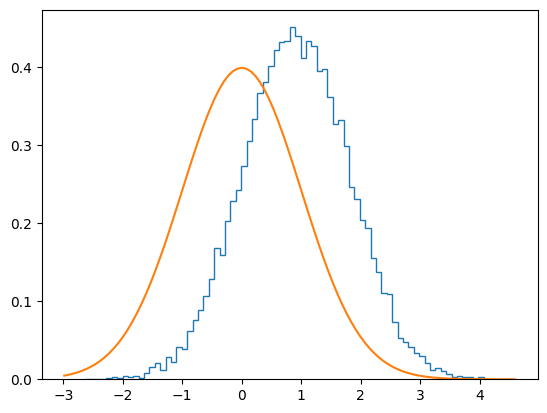

In [71]:
plt.figure()
plt.hist(all_dr, bins="auto", histtype='step', density=True)
xrange = np.linspace(*plt.xlim(), 100)
plt.plot(xrange, norm(0, 1).pdf(xrange), )

plt.show()

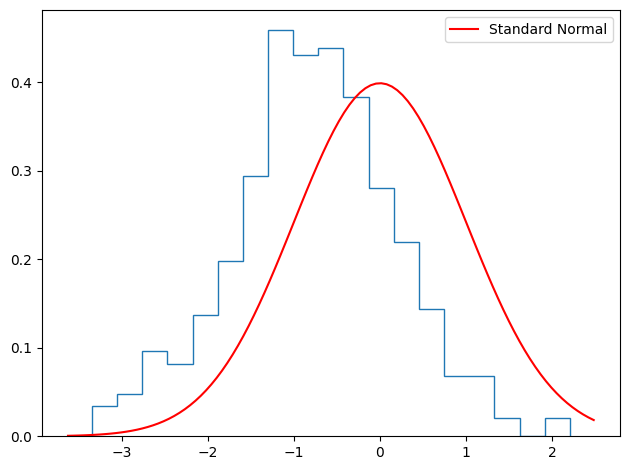

In [72]:
H0_bias = np.mean(all_H0_samples - H0, axis=1) / np.std(all_H0_samples, axis=1)

# H0_bias_corrected = np.load("H0_bias_corrected.npy")
plt.figure()
plt.hist(H0_bias, bins="auto", histtype='step', density=True, )
# plt.hist(H0_bias_corrected, bins="auto", histtype='step', density=True, label="Selection modelled")
xrange = np.linspace(*plt.xlim(), 100)
plt.plot(xrange, norm(0, 1).pdf(xrange), c='red', label="Standard Normal")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/H0_bias_histogram.png")
plt.show()

In [ ]:
# np.save("/Users/rstiskalek/Projects/CANDEL/results/CH0/bias_test/H0_bias_SN_selection_not_accountted.npy", H0_bias)